In [135]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pickle as pkl
import cv2
import imutils
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2, DenseNet121, VGG19, EfficientNetB7, InceptionV3
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_v2_preprocess_input
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_v3_preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Conv2DTranspose, Reshape, Input, ReLU, LeakyReLU
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [136]:
""" Dataset directories """
dataset_dir = "dataset"

In [137]:
""" Get the first image from the healthy directory """
first_image_file = os.listdir(f"{dataset_dir}/Non Demented")[0]
img = plt.imread(f"{dataset_dir}/Non Demented/{first_image_file}")

img_height, img_width, _ = img.shape

# img_size = 224
img_size = min(img_height, img_width)

print(f"Image size: {img_height}x{img_width} -> {img_size}")

Image size: 248x496 -> 248


In [138]:
""" Set batch size """
batch_size = 16

#### General preprocessing and augmentation

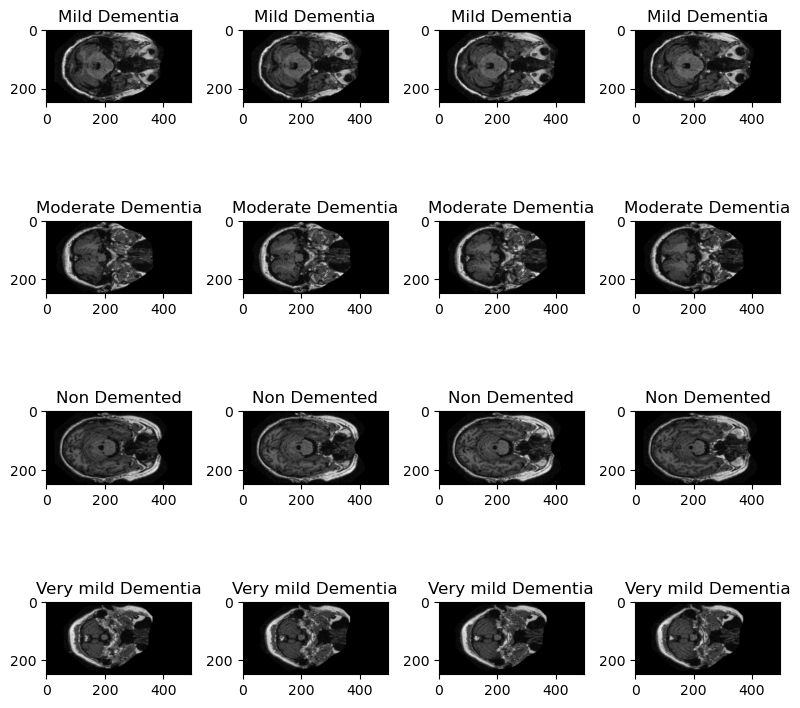

In [139]:
""" Display raw images from different classes """
plt.figure(figsize=(8, 8))

for i, subdir in enumerate(os.listdir(dataset_dir)):
    subdir_path = os.path.join(dataset_dir, subdir)
    img_files = os.listdir(subdir_path)[:4]
    
    for j, img_file in enumerate(img_files):
        img_path = os.path.join(subdir_path, img_file)
        img = plt.imread(img_path)

        plt.subplot(4, 4, i*4 + j + 1)
        plt.imshow(img)
        plt.title(subdir)
    
plt.tight_layout()
plt.show()

In [140]:
# plt.figure(figsize=(16, 8))

# # Display sample training images
# for i in range(9):
#     plt.subplot(3, 6, i + 1)
#     for X_batch, Y_batch in train_generator:
#         image = X_batch[0]
#         label = Y_batch[0]
#         plt.imshow(image)
#         plt.title("Train: " + class_labels[np.argmax(label)])
#         break

# # Display sample test images
# for i in range(9):
#     plt.subplot(3, 6, i + 10)
#     for X_batch, Y_batch in test_generator:
#         image = X_batch[0]
#         label = Y_batch[0]
#         plt.imshow(image)
#         plt.title("Test: " + class_labels[np.argmax(label)])
#         break

# plt.tight_layout()
# plt.show()

#### Custom preprocessing

In [141]:
prep_dir = "dataset_preprocessed"

In [142]:
def enhance_image(img):
    # Convert image to grayscale
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_img = clahe.apply(grayscale_img)

    # Apply Laplacian sharpening to enhance details
    laplacian = cv2.Laplacian(equalized_img, cv2.CV_8U, ksize=3)

    # Add the original image with the sharpened details
    sharpened_img = cv2.addWeighted(equalized_img, 1.5, laplacian, -0.5, 0)

    return sharpened_img


def crop_image(img, add_pixels_value=1):
    enhanced_img = enhance_image(img)

    # gray = cv2.cvtColor(enhanced_img , cv2.COLOR_RGB2GRAY)  # Convert image to grayscale
    gray_blur = cv2.GaussianBlur(enhanced_img, (5, 5), 0)  # Apply Gaussian blur to reduce noise
    _, thresh = cv2.threshold(gray_blur, 45, 255, cv2.THRESH_BINARY)  # Thresholding to create a binary image

    # Morphological operations (erosion and dilation) to remove noise
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)

    # If no contours found, return original image
    if len(contours) == 0:
        return enhanced_img

    largest_contour = max(contours, key=cv2.contourArea)  # Get the largest contour

    x, y, w, h = cv2.boundingRect(largest_contour)  # Get the bounding box of the largest contour

    # Add extra pixels to the bounding box if specified
    x -= add_pixels_value
    y -= add_pixels_value
    w += add_pixels_value * 2
    h += add_pixels_value * 2

    # Ensure the bounding box coordinates are within image bounds
    x = max(x, 0)
    y = max(y, 0)
    w = min(w, img.shape[1])
    h = min(h, img.shape[0])

    cropped_img = enhanced_img[y : y + h, x : x + w].copy()  # Crop the image using the bounding box

    resized_img = cv2.resize(cropped_img, (img_size, img_size))  # Resize the cropped image

    return resized_img


""" Preprocess images """
if not os.path.exists(prep_dir):
    os.makedirs(prep_dir)

for subdir in os.listdir(dataset_dir):
    subdir_path = os.path.join(dataset_dir, subdir)

    new_subdir_path = os.path.join(prep_dir, subdir)
    if not os.path.exists(new_subdir_path):
        os.makedirs(new_subdir_path)

    for filename in os.listdir(subdir_path):
        img_path = os.path.join(subdir_path, filename)
        img = plt.imread(img_path)

        preprocessed_img = crop_image(img)

        new_filename = os.path.join(new_subdir_path, filename)
        plt.imsave(new_filename, preprocessed_img)

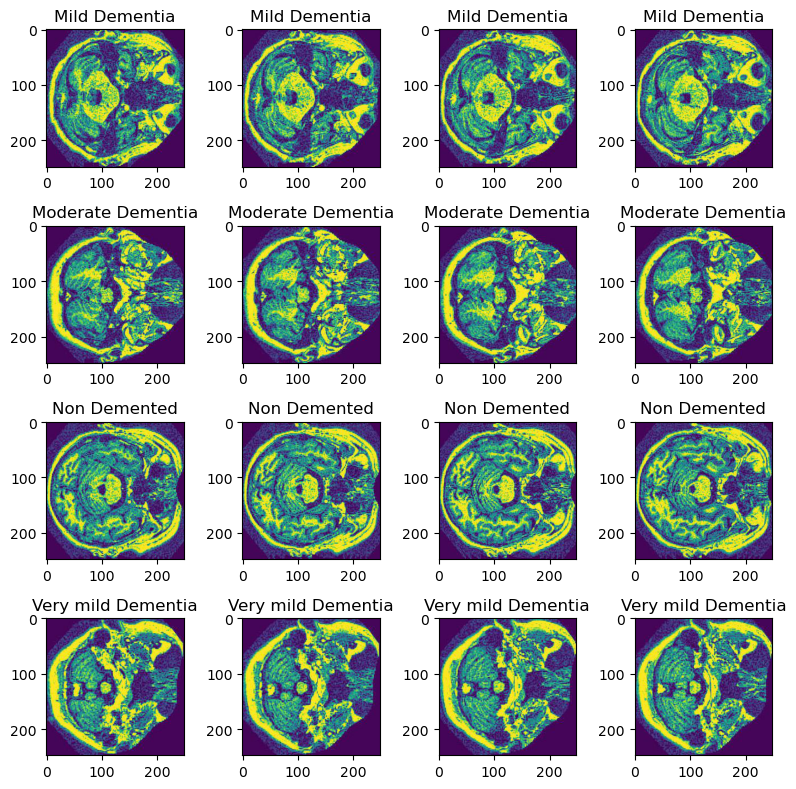

In [143]:
""" Display raw images from different classes """
plt.figure(figsize=(8, 8))

for i, subdir in enumerate(os.listdir(prep_dir)):
    subdir_path = os.path.join(prep_dir, subdir)
    img_files = os.listdir(subdir_path)[:4]
    
    for j, img_file in enumerate(img_files):
        img_path = os.path.join(subdir_path, img_file)
        img = plt.imread(img_path)

        plt.subplot(4, 4, i*4 + j + 1)
        plt.imshow(img)
        plt.title(subdir)
    
plt.tight_layout()
plt.show()

In [123]:
# def adjust_contrast(img):
#     return tf.image.adjust_contrast(img, contrast_factor=2.0)

# def sharpen_image(image):
#     kernel = tf.constant([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]], dtype=tf.float32)
#     kernel = tf.reshape(kernel, [3, 3, 1, 1])
#     image = tf.expand_dims(image, axis=-1)
#     sharpened_image = tf.nn.conv2d(image, kernel, strides=[1, 1, 1, 1], padding="SAME")

#     alpha = 0.9
#     image = alpha * image + (1 - alpha) * sharpened_image

#     return tf.squeeze(image, axis=-1)

# def prep_image(img):
#     img = tf.image.rgb_to_grayscale(img)
#     img = adjust_contrast(img)
#     img = sharpen_image(img)
#     img = tf.image.grayscale_to_rgb(img)
#     img.set_shape([None, None, 3])
#     return img

In [124]:
""" Model configuration """
epochs_number = 200

""" Set optimizer """
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
#optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

""" Set early stopping """
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, min_delta=0.001, restore_best_weights=True)

""" Set learning rate annealer """
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.8, min_lr=0.00001)

#### Testing ResNet-50 V2 model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Found 8540 images belonging to 4 classes.
Found 948 images belonging to 4 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

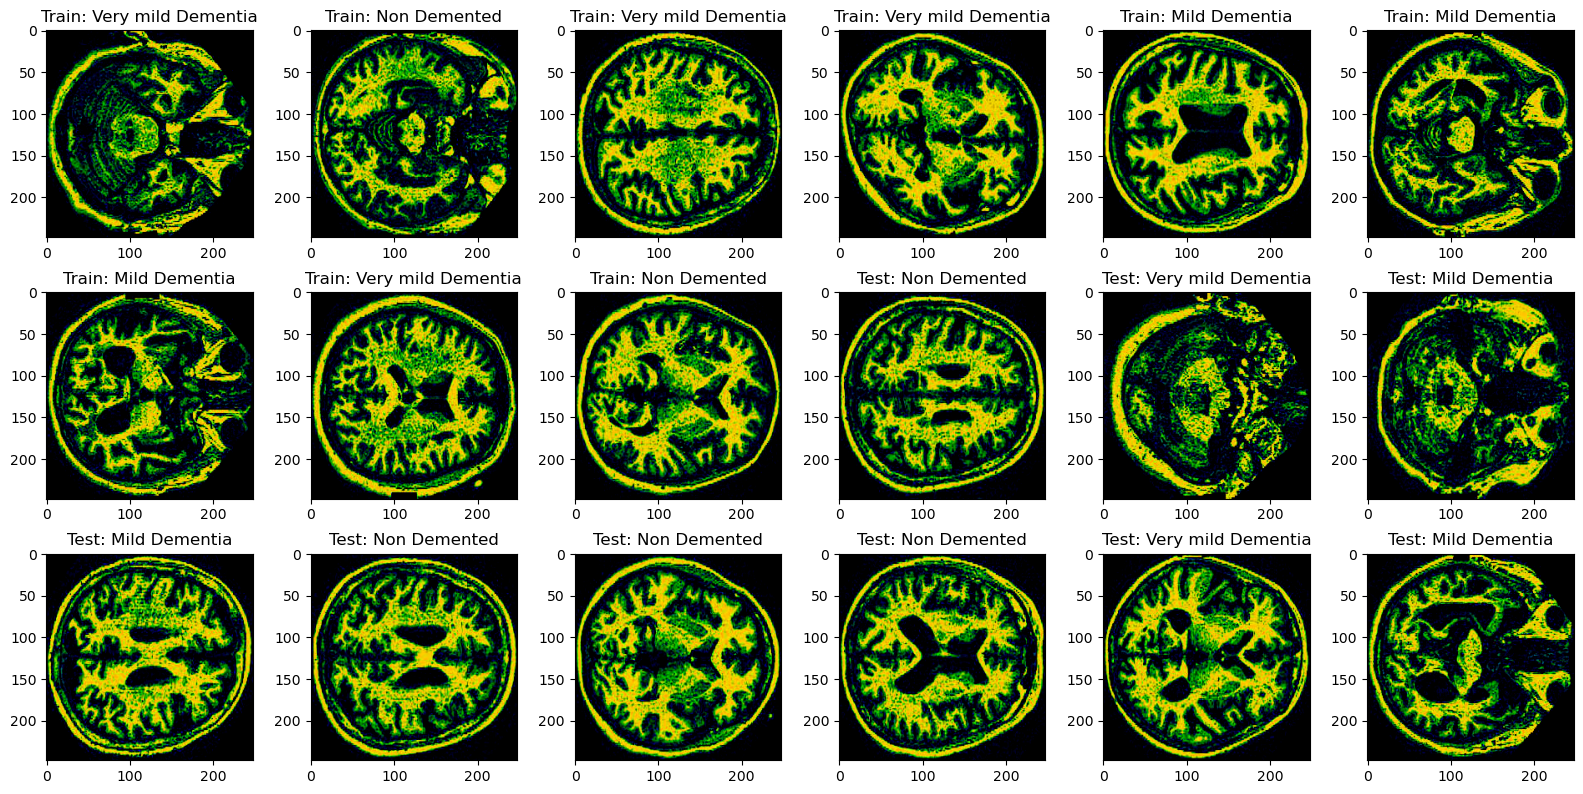

In [125]:
datagen = ImageDataGenerator(
    preprocessing_function=resnet_v2_preprocess_input,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # vertical_flip=True,
    # height_shift_range=0.2,
    # width_shift_range=0.2,
    # rotation_range=45,
    validation_split=0.1,
)

train_generator = datagen.flow_from_directory(prep_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode="categorical", subset="training", shuffle=True, seed=42)
test_generator = datagen.flow_from_directory(prep_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode="categorical", subset="validation", shuffle=True, seed=42)

""" Get class labels """
class_labels = list(train_generator.class_indices.keys())

plt.figure(figsize=(16, 8))

""" Display sample training images """
for i in range(9):
    plt.subplot(3, 6, i + 1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        label = Y_batch[0]
        plt.imshow(image)
        plt.title("Train: " + class_labels[np.argmax(label)])
        break

""" Display sample test images """
for i in range(9):
    plt.subplot(3, 6, i + 10)
    for X_batch, Y_batch in test_generator:
        image = X_batch[0]
        label = Y_batch[0]
        plt.imshow(image)
        plt.title("Test: " + class_labels[np.argmax(label)])
        break

plt.tight_layout()
plt.show()

In [126]:
""" Number of classes"""
num_classes = len(class_labels)

In [127]:
def SamplesPerClass(dir_path):
    num_samples = []
    class_labels = os.listdir(dir_path)
    for class_label in class_labels:
        class_dir = os.path.join(prep_dir, class_label)
        if os.path.isdir(class_dir):
            num_samples.append(len(os.listdir(class_dir)))
    return np.array(num_samples)

In [128]:
num_samples = SamplesPerClass(prep_dir)
total_samples = np.sum(num_samples)
class_frequencies = num_samples / total_samples
inverse_class_frequencies = 1 / class_frequencies
class_weights = inverse_class_frequencies / np.sum(inverse_class_frequencies)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

class_weights_dict

{0: 0.1093189964157706,
 1: 0.6720430107526881,
 2: 0.1093189964157706,
 3: 0.1093189964157706}

In [129]:
""" Load ResNet50V2 model """
base_resNet_model = ResNet50V2(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

""" Freeze the base model """
for layer in base_resNet_model.layers:
    layer.trainable = False
    
""" Add custom layers """
x = base_resNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation="softmax")(x)

""" Create model """
resnet_model = Model(inputs=base_resNet_model.input, outputs=predictions)

""" Compile model """
resnet_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
""" Train model """
resNet_history = resnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs_number,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    class_weight=class_weights_dict,
    callbacks=[learning_rate_reduction, early_stopping],
)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

""" Plot training and validation accuracy """
axs[0].plot(resNet_history.history["accuracy"], label="Training accuracy")
axs[0].plot(resNet_history.history["val_accuracy"], label="Validation accuracy")
axs[0].set_title("Training and validation accuracy - ResNet50V2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

""" Plot training and validation loss """
axs[1].plot(resNet_history.history["loss"], label="Training loss")
axs[1].plot(resNet_history.history["val_loss"], label="Validation loss")
axs[1].set_title("Training and validation loss - ResNet50V2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
""" Save model """
resnet_model.save('resNet_model.h5')

""" Save history """
with open("resNet_history.pkl", "wb") as f:
    pkl.dump(resNet_history.history, f)

c:\ProgramData\anaconda3\envs\tf_env\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


#### Testing DenseNet-121 model


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Found 8540 images belonging to 4 classes.
Found 948 images belonging to 4 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

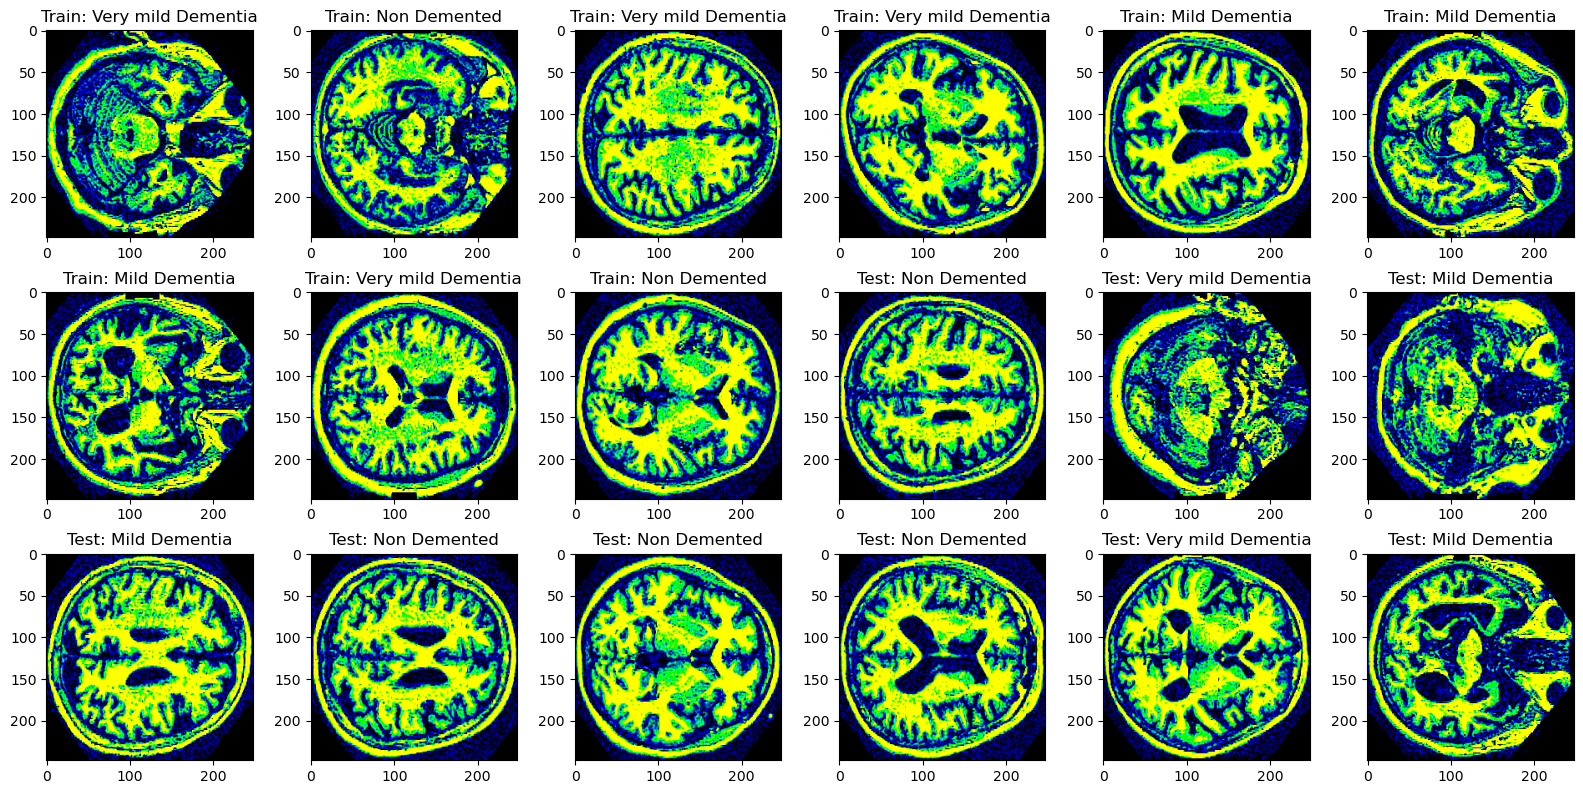

In [130]:
datagen = ImageDataGenerator(
    preprocessing_function=densenet_preprocess_input,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # vertical_flip=True,
    # height_shift_range=0.2,
    # width_shift_range=0.2,
    # rotation_range=45,
    validation_split=0.1,
)

train_generator = datagen.flow_from_directory(prep_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode="categorical", subset="training", shuffle=True, seed=42)
test_generator = datagen.flow_from_directory(prep_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode="categorical", subset="validation", shuffle=True, seed=42)

plt.figure(figsize=(16, 8))

""" Display sample training images """
for i in range(9):
    plt.subplot(3, 6, i + 1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        label = Y_batch[0]
        plt.imshow(image)
        plt.title("Train: " + class_labels[np.argmax(label)])
        break

""" Display sample test images """
for i in range(9):
    plt.subplot(3, 6, i + 10)
    for X_batch, Y_batch in test_generator:
        image = X_batch[0]
        label = Y_batch[0]
        plt.imshow(image)
        plt.title("Test: " + class_labels[np.argmax(label)])
        break

plt.tight_layout()
plt.show()

In [131]:
# Load pre-trained DenseNet121 model
base_denseNet_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

# Freeze convolutional layers
for layer in base_denseNet_model.layers:
    layer.trainable = False
    
# Add custom classification head
x = base_denseNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation="softmax")(x)

# Create model
denseNet_model = Model(inputs=base_denseNet_model.input, outputs=predictions)

# Compile model
denseNet_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
""" Train model """
denseNet_history = denseNet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs_number,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    class_weight=class_weights_dict,
    callbacks=[learning_rate_reduction, early_stopping],
)

Epoch 1/100
533/533 [==============================] - 50s 83ms/step - loss: 1.2937 - accuracy: 0.3150 - val_loss: 1.2442 - val_accuracy: 0.3167
Epoch 2/100
533/533 [==============================] - 43s 80ms/step - loss: 1.2500 - accuracy: 0.3134 - val_loss: 1.2422 - val_accuracy: 0.3167
Epoch 3/100
533/533 [==============================] - 42s 80ms/step - loss: 1.2484 - accuracy: 0.3160 - val_loss: 1.2459 - val_accuracy: 0.3178
Epoch 4/100
533/533 [==============================] - 42s 79ms/step - loss: 1.2479 - accuracy: 0.3131 - val_loss: 1.2439 - val_accuracy: 0.3178
Epoch 5/100
533/533 [==============================] - 43s 80ms/step - loss: 1.2461 - accuracy: 0.3153 - val_loss: 1.2439 - val_accuracy: 0.3157
Epoch 6/100
533/533 [==============================] - 42s 79ms/step - loss: 1.2475 - accuracy: 0.3163 - val_loss: 1.2429 - val_accuracy: 0.3157
Epoch 7/100
533/533 [==============================] - 42s 79ms/step - loss: 1.2474 - accuracy: 0.3143 - val_loss: 1.2421 - val_ac

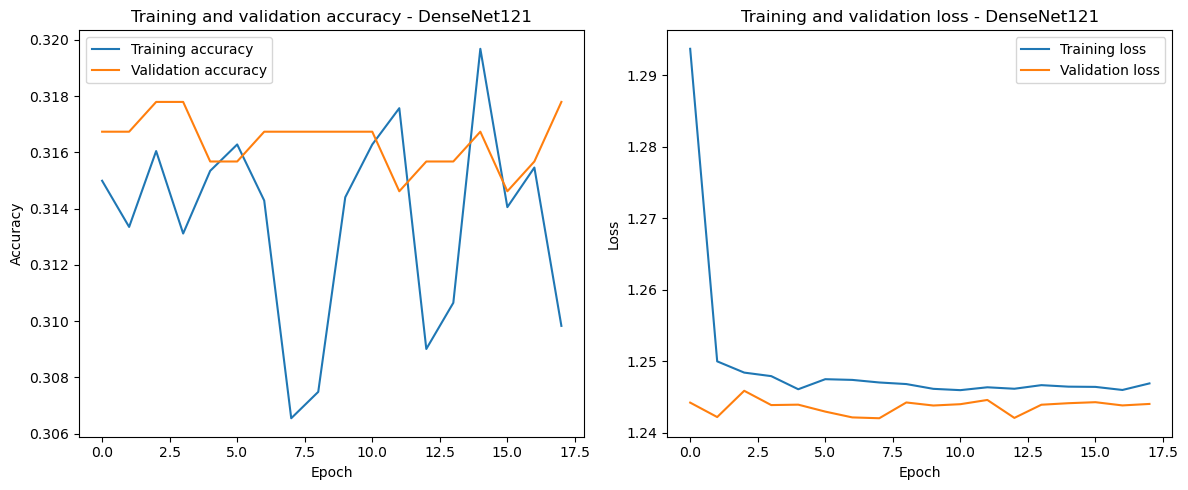

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation accuracy
axs[0].plot(denseNet_history.history["accuracy"], label="Training accuracy")
axs[0].plot(denseNet_history.history["val_accuracy"], label="Validation accuracy")
axs[0].set_title("Training and validation accuracy - DenseNet121")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# Plot training and validation loss
axs[1].plot(denseNet_history.history["loss"], label="Training loss")
axs[1].plot(denseNet_history.history["val_loss"], label="Validation loss")
axs[1].set_title("Training and validation loss - DenseNet121")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save trained model
denseNet_model.save("denseNet_model.h5")

# Save history
with open("denseNet_history.pkl", "wb") as f:
    pkl.dump(denseNet_history.history, f)

#### Testing VGG19 model


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Found 8540 images belonging to 4 classes.
Found 948 images belonging to 4 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

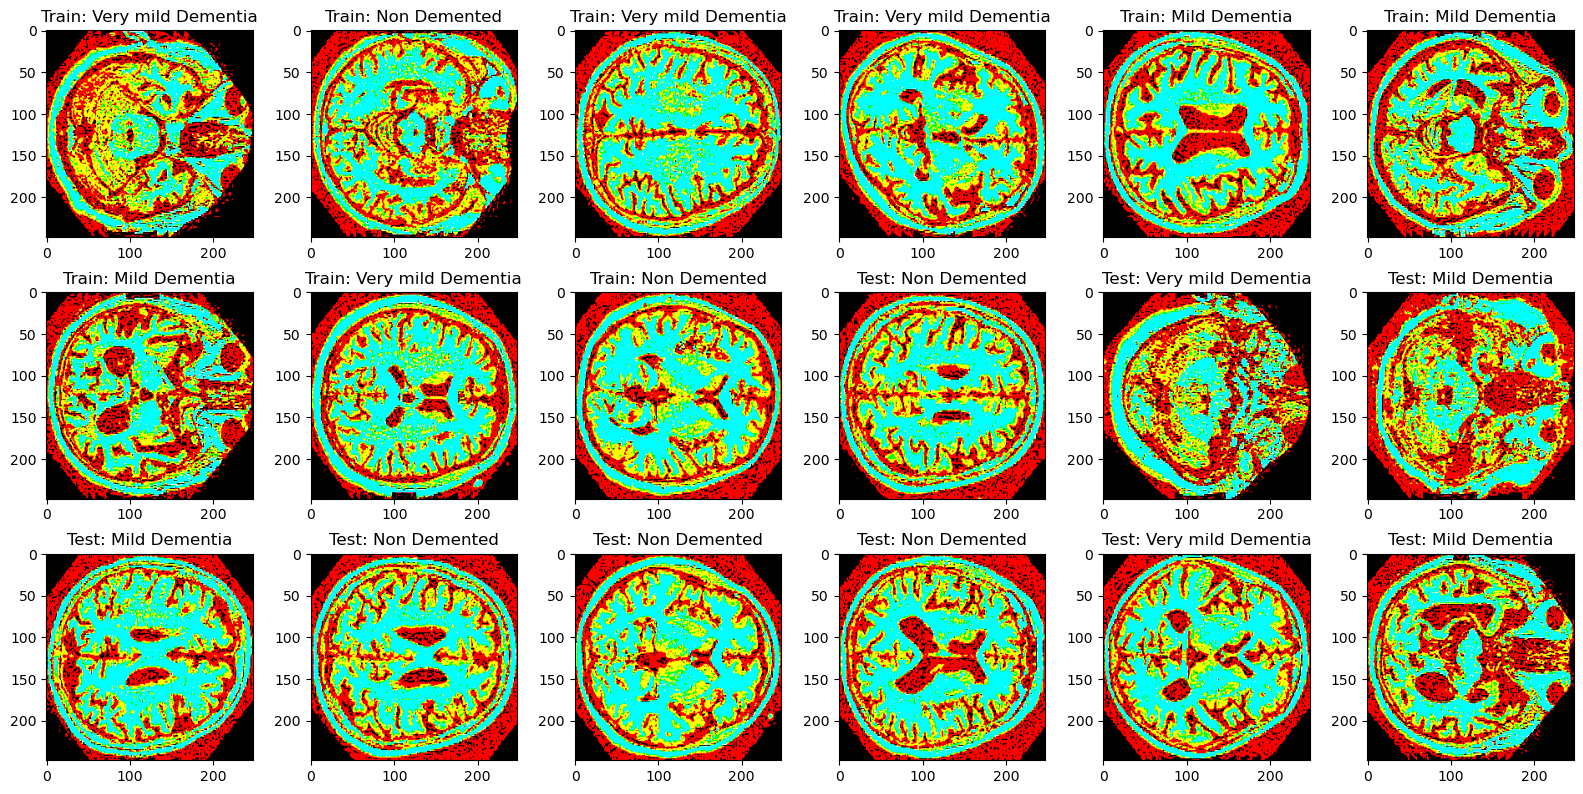

In [132]:
datagen = ImageDataGenerator(
    preprocessing_function=vgg19_preprocess_input,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # vertical_flip=True,
    # height_shift_range=0.2,
    # width_shift_range=0.2,
    # rotation_range=45,
    validation_split=0.1,
)

train_generator = datagen.flow_from_directory(prep_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode="categorical", subset="training", shuffle=True, seed=42)
test_generator = datagen.flow_from_directory(prep_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode="categorical", subset="validation", shuffle=True, seed=42)

plt.figure(figsize=(16, 8))

""" Display sample training images """
for i in range(9):
    plt.subplot(3, 6, i + 1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        label = Y_batch[0]
        plt.imshow(image)
        plt.title("Train: " + class_labels[np.argmax(label)])
        break

""" Display sample test images """
for i in range(9):
    plt.subplot(3, 6, i + 10)
    for X_batch, Y_batch in test_generator:
        image = X_batch[0]
        label = Y_batch[0]
        plt.imshow(image)
        plt.title("Test: " + class_labels[np.argmax(label)])
        break

plt.tight_layout()
plt.show()

In [133]:
""" Load the VGG19 model """
base_vgg_model = VGG19(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

# Freeze convolutional layers
for layer in base_vgg_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_vgg_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation="softmax")(x)

# Create model
vgg_model = Model(inputs=base_vgg_model.input, outputs=predictions)

# Compile model
vgg_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Train the model
vgg_history = vgg_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs_number,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    class_weight=class_weights_dict,
    callbacks=[learning_rate_reduction, early_stopping],
)

Epoch 1/100
533/533 [==============================] - 98s 159ms/step - loss: 1.2993 - accuracy: 0.3138 - val_loss: 1.2455 - val_accuracy: 0.3157
Epoch 2/100
533/533 [==============================] - 81s 153ms/step - loss: 1.2492 - accuracy: 0.3190 - val_loss: 1.2455 - val_accuracy: 0.3157
Epoch 3/100
533/533 [==============================] - 82s 154ms/step - loss: 1.2479 - accuracy: 0.3165 - val_loss: 1.2441 - val_accuracy: 0.3157
Epoch 4/100
533/533 [==============================] - 82s 153ms/step - loss: 1.2481 - accuracy: 0.3184 - val_loss: 1.2442 - val_accuracy: 0.3146
Epoch 5/100
533/533 [==============================] - 82s 154ms/step - loss: 1.2479 - accuracy: 0.3148 - val_loss: 1.2424 - val_accuracy: 0.3178
Epoch 6/100
533/533 [==============================] - 81s 152ms/step - loss: 1.2463 - accuracy: 0.3184 - val_loss: 1.2440 - val_accuracy: 0.3167
Epoch 7/100
533/533 [==============================] - 82s 153ms/step - loss: 1.2472 - accuracy: 0.3103 - val_loss: 1.2442 -

In [ ]:
# Save the trained model
vgg_model.save("efficientNet_model.h5")

# Save the history
with open("efficientNet_history.pkl", "wb") as f:
    pkl.dump(vgg_history.history, f)

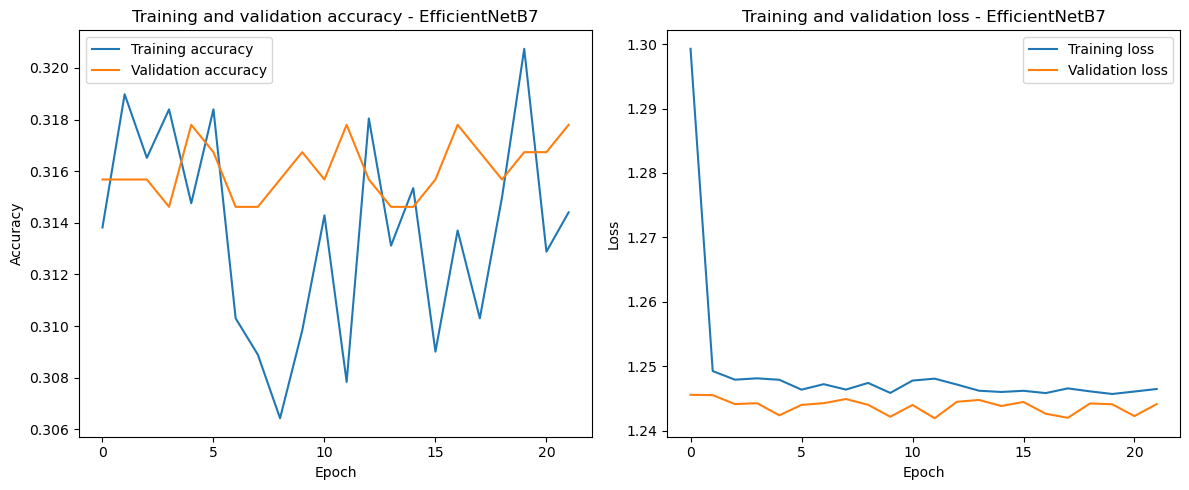

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation accuracy
axs[0].plot(vgg_history.history["accuracy"], label="Training accuracy")
axs[0].plot(vgg_history.history["val_accuracy"], label="Validation accuracy")
axs[0].set_title("Training and validation accuracy - EfficientNetB7")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# Plot training and validation loss
axs[1].plot(vgg_history.history["loss"], label="Training loss")
axs[1].plot(vgg_history.history["val_loss"], label="Validation loss")
axs[1].set_title("Training and validation loss - EfficientNetB7")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

#### Testing custom CNN model

Found 8540 images belonging to 4 classes.
Found 948 images belonging to 4 classes.


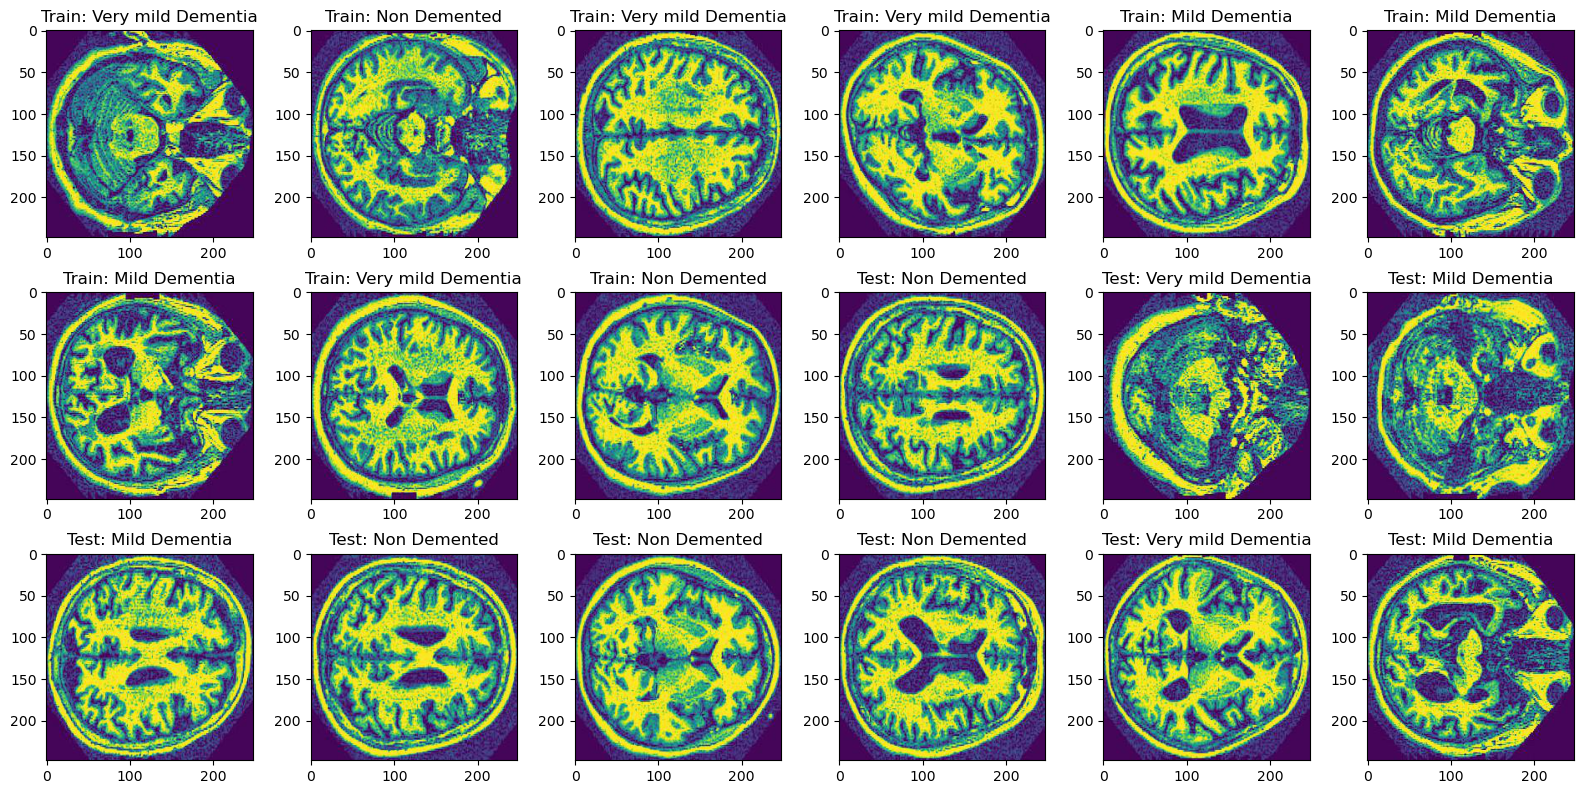

In [134]:
# datagen = ImageDataGenerator(
#     rescale=1.0 / 255.0,
#     # shear_range=0.2,
#     # zoom_range=0.2,
#     # horizontal_flip=True,
#     # vertical_flip=True,
#     # height_shift_range=0.2,
#     # width_shift_range=0.2,
#     # rotation_range=45,
#     validation_split=0.1,
# )

# train_generator = datagen.flow_from_directory(prep_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode="categorical", subset="training", shuffle=True, seed=42)
# test_generator = datagen.flow_from_directory(prep_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode="categorical", subset="validation", shuffle=True, seed=42)

# plt.figure(figsize=(16, 8))

# """ Display sample training images """
# for i in range(9):
#     plt.subplot(3, 6, i + 1)
#     for X_batch, Y_batch in train_generator:
#         image = X_batch[0]
#         label = Y_batch[0]
#         plt.imshow(image)
#         plt.title("Train: " + class_labels[np.argmax(label)])
#         break

# """ Display sample test images """
# for i in range(9):
#     plt.subplot(3, 6, i + 10)
#     for X_batch, Y_batch in test_generator:
#         image = X_batch[0]
#         label = Y_batch[0]
#         plt.imshow(image)
#         plt.title("Test: " + class_labels[np.argmax(label)])
#         break

# plt.tight_layout()
# plt.show()

In [ ]:
# # Custom CNN architecture
# custom_model = Sequential(
#     [
#         Conv2D(32, (3, 3), activation="relu", input_shape=(img_size, img_size, 3)),
#         MaxPooling2D((2, 2)),
#         Conv2D(64, (3, 3), activation="relu"),
#         MaxPooling2D((2, 2)),
#         Conv2D(128, (3, 3), activation="relu"),
#         MaxPooling2D((2, 2)),
#         Conv2D(128, (3, 3), activation="relu"),
#         MaxPooling2D((2, 2)),
#         Flatten(),
#         Dense(512, activation="relu"),
#         Dropout(0.5),
#         Dense(num_classes, activation="softmax"),
#     ]
# )

# # Compile the model
# custom_model.compile(optimizer=adam_optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
# # custom_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", f1_m])

In [ ]:
# # Train the model
# custom_CNN_history = custom_model.fit(
#     train_generator, steps_per_epoch=train_generator.samples // batch_size, epochs=epochs_number, validation_data=test_generator, validation_steps=test_generator.samples // batch_size, callbacks=[learning_rate_reduction, early_stopping]
# )

In [ ]:
# # Save the trained model
# custom_model.save("custom_CNN_model.h5")

In [ ]:
# plt.plot(custom_CNN_history.history["accuracy"], label="Training accuracy")
# plt.plot(custom_CNN_history.history["val_accuracy"], label="Validation accuracy")
# plt.title("Training and validation accuracy - Custom CNN")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.show()

#### Evaluate models


In [ ]:
# Table comparing the performance of models
resNet_accuracy = resNet_history.history["accuracy"][-1]
resNet_val_accuracy = resNet_history.history["val_accuracy"][-1]
denseNet_accuracy = denseNet_history.history["accuracy"][-1]
denseNet_val_accuracy = denseNet_history.history["val_accuracy"][-1]
vgg_accuracy = vgg_history.history["accuracy"][-1]
vgg_val_accuracy = vgg_history.history["val_accuracy"][-1]
# custom_CNN_accuracy = custom_CNN_history.history["accuracy"][-1]
# custom_CNN_val_accuracy = custom_CNN_history.history["val_accuracy"][-1]

model_comparison = pd.DataFrame(
    {
        "Model": ["ResNet50V2", "DenseNet121", "VGG19"],
        "Train Accuracy": [resNet_accuracy, denseNet_accuracy, vgg_accuracy],
        "Validation Accuracy": [resNet_val_accuracy, denseNet_val_accuracy, vgg_val_accuracy],
    }
)

model_comparison

Model  Train Accuracy  Validation Accuracy
0      ResNet50V2        0.863679             0.352754
1     DenseNet121        0.309831             0.317797
2  EfficientNetB7        0.314406             0.317797

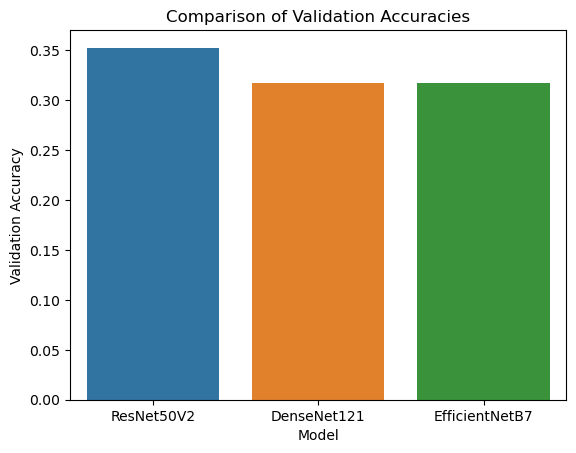

In [ ]:
sns.barplot(x="Model", y="Validation Accuracy", data=model_comparison)
plt.title("Comparison of Validation Accuracies")
plt.show()